<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/Haleakala_subregion_climate_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 98.0 MB/s eta 0:00:00


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load your tiffs
with rasterio.open('/content/T_max_ann_subregion.tif') as src:
    temp = src.read(1)  # Read first band
    temp_meta = src.meta  # Save metadata if needed
    nodata_temp = src.nodata

with rasterio.open('/content/rainfall_ann_mm_subregion.tif') as src:
    rain = src.read(1)
    nodata_rain = src.nodata

# Check what you've got
print(f"Temperature shape: {temp.shape}")
print(f"Rainfall shape: {rain.shape}")
print(f"Temp range: {temp.min()} to {temp.max()}")
print(f"Rain range: {rain.min()} to {rain.max()}")

Temperature shape: (85, 111)
Rainfall shape: (85, 112)
Temp range: -3.4028234663852886e+38 to 28.35157585144043
Rain range: -9999.0 to 6067.614


In [4]:
from rasterio.warp import reproject, Resampling

# Reload and resample rain to match temp
with rasterio.open('/content/T_max_ann_subregion.tif') as temp_src:
    temp = temp_src.read(1).astype(float)
    temp_meta = temp_src.meta.copy()

with rasterio.open('/content/rainfall_ann_mm_subregion.tif') as rain_src:
    rain_data = rain_src.read(1).astype(float)

    # Create empty array with temp's shape
    rain = np.empty(temp.shape, dtype=np.float32)
    rain.fill(-9999)  # Initialize with nodata

    # Reproject rain to match temp
    reproject(
        source=rain_data,
        destination=rain,
        src_transform=rain_src.transform,
        src_crs=rain_src.crs,
        src_nodata=-9999,  # Specify nodata value
        dst_transform=temp_src.transform,
        dst_crs=temp_src.crs,
        dst_nodata=-9999,  # Specify nodata value
        resampling=Resampling.nearest  # Use nearest neighbor to avoid interpolation
    )

print(f"Resampled shapes - Temp: {temp.shape}, Rain: {rain.shape}")

# Replace -9999 AND any suspicious values with nan
temp[temp == -9999] = np.nan
temp[temp < -100] = np.nan  # Catch any extreme artifacts
rain[rain == -9999] = np.nan
rain[rain < -100] = np.nan  # Catch any extreme artifacts

# Now create mask
valid_mask = ~np.isnan(temp) & ~np.isnan(rain)
temp_vals = temp[valid_mask]
rain_vals = rain[valid_mask]

print(f"Total pixels: {temp.size}")
print(f"Valid pixels: {valid_mask.sum()}")
print(f"Temperature range: {np.nanmin(temp):.1f} to {np.nanmax(temp):.1f}")
print(f"Rainfall range: {np.nanmin(rain):.1f} to {np.nanmax(rain):.1f}")

Resampled shapes - Temp: (85, 111), Rain: (85, 111)
Total pixels: 9435
Valid pixels: 6431
Temperature range: 15.4 to 28.4
Rainfall range: 341.8 to 6067.6


In [5]:
# Create mask for valid pixels (both rasters have data)
valid_mask = ~np.isnan(temp) & ~np.isnan(rain)

# Extract valid values for analysis
temp_vals = temp[valid_mask]
rain_vals = rain[valid_mask]

print(f"Total pixels: {temp.size}")
print(f"Valid pixels: {valid_mask.sum()}")
print(f"Temperature range: {np.nanmin(temp):.1f} to {np.nanmax(temp):.1f}")
print(f"Rainfall range: {np.nanmin(rain):.1f} to {np.nanmax(rain):.1f}")

Total pixels: 9435
Valid pixels: 6431
Temperature range: 15.4 to 28.4
Rainfall range: 341.8 to 6067.6


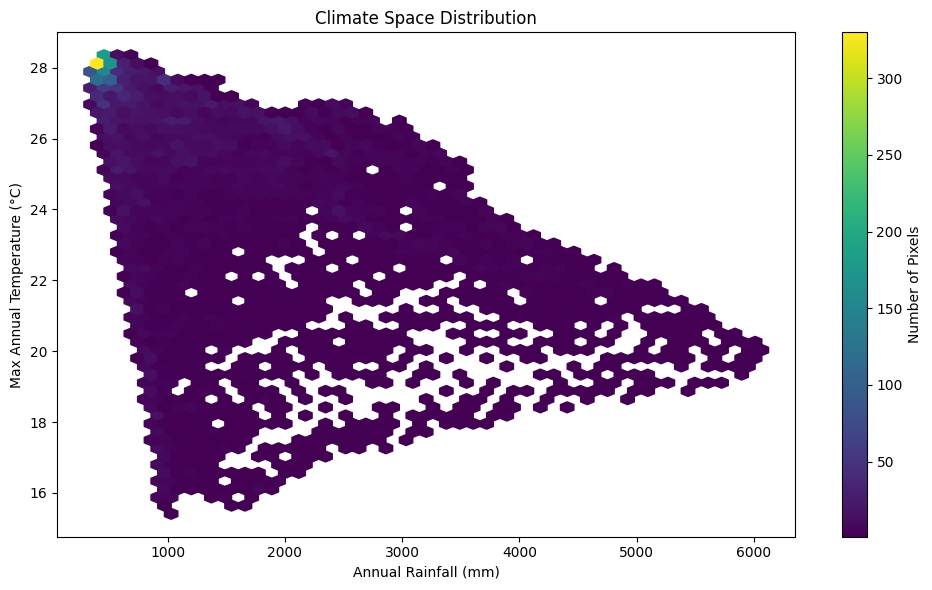

In [6]:
# Visualize the climate space
plt.figure(figsize=(10, 6))
plt.hexbin(rain_vals, temp_vals, gridsize=50, cmap='viridis', mincnt=1)
plt.xlabel('Annual Rainfall (mm)')
plt.ylabel('Max Annual Temperature (°C)')
plt.colorbar(label='Number of Pixels')
plt.title('Climate Space Distribution')
plt.tight_layout()
plt.show()

Temperature bins:
  Bin 0 (Cool): 15-22°C
  Bin 1 (Moderate): 22-26°C
  Bin 2 (Warm): 26-29°C

Rainfall bins:
  Bin 0 (Dry): 300-500 mm
  Bin 1 (Moderate): 500-2000 mm
  Bin 2 (Wet): 2000-6100 mm

Climate Bin Distribution for Maui
Bin ID | Temp      | Rain     | Pixel Count | % of Total
------------------------------------------------------------
   1   | Cool      | Moderate |      703    |   10.9%
   2   | Cool      | Wet      |      498    |    7.7%
  10   | Moderate  | Dry      |       24    |    0.4%
  11   | Moderate  | Moderate |     1298    |   20.2%
  12   | Moderate  | Wet      |      954    |   14.8%
  20   | Warm      | Dry      |     1247    |   19.4%
  21   | Warm      | Moderate |     1522    |   23.7%
  22   | Warm      | Wet      |      185    |    2.9%
------------------------------------------------------------
Total valid pixels: 6431
Number of bins: 8


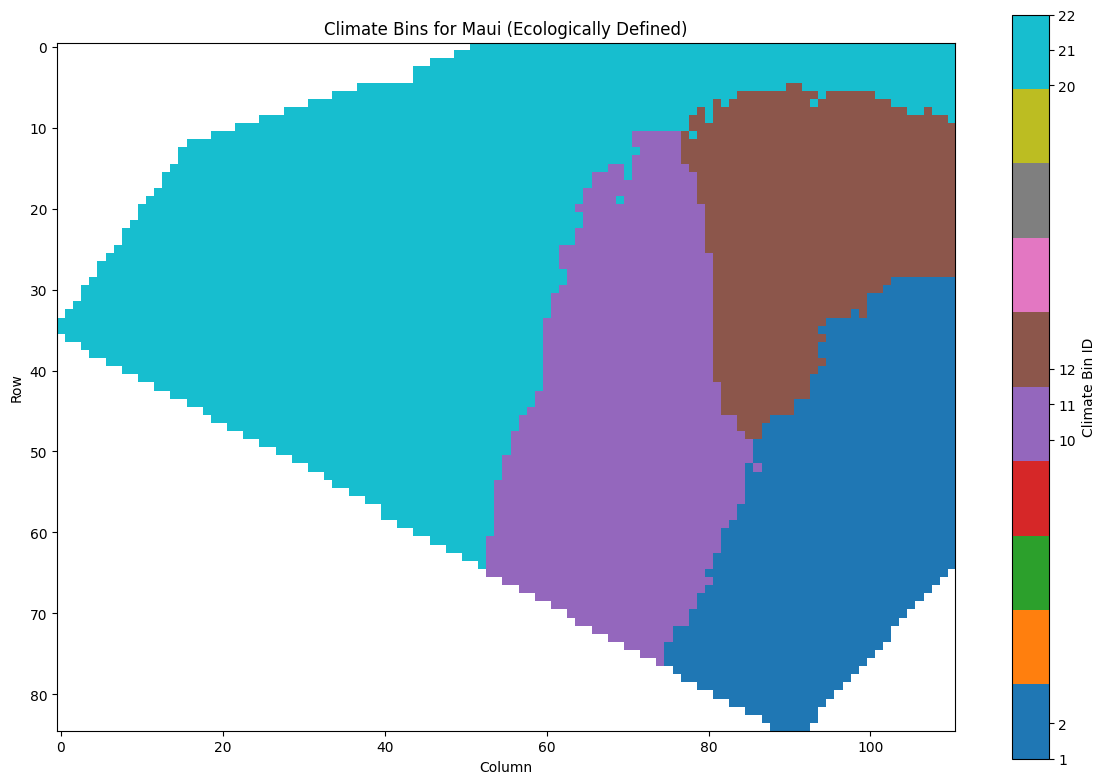

In [7]:
# Ecologically meaningful bins for Maui
temp_edges = [15, 22, 26, 29]  # Cool, Moderate, Warm
rain_edges = [300, 500, 2000, 6100]  # Dry, Moderate, Wet

print("Temperature bins:")
print(f"  Bin 0 (Cool): {temp_edges[0]}-{temp_edges[1]}°C")
print(f"  Bin 1 (Moderate): {temp_edges[1]}-{temp_edges[2]}°C")
print(f"  Bin 2 (Warm): {temp_edges[2]}-{temp_edges[3]}°C")

print("\nRainfall bins:")
print(f"  Bin 0 (Dry): {rain_edges[0]}-{rain_edges[1]} mm")
print(f"  Bin 1 (Moderate): {rain_edges[1]}-{rain_edges[2]} mm")
print(f"  Bin 2 (Wet): {rain_edges[2]}-{rain_edges[3]} mm")

# Apply the bins
temp_binned = np.digitize(temp, temp_edges, right=False) - 1
temp_binned = np.clip(temp_binned, 0, 2)

rain_binned = np.digitize(rain, rain_edges, right=False) - 1
rain_binned = np.clip(rain_binned, 0, 2)

# Set invalid pixels to -1
temp_binned[~valid_mask] = -1
rain_binned[~valid_mask] = -1

# Create combined bin ID
bin_id = np.full(temp.shape, -9999)
bin_id[valid_mask] = temp_binned[valid_mask] * 10 + rain_binned[valid_mask]

# Check bin counts
unique_bins, bin_counts = np.unique(bin_id[valid_mask], return_counts=True)

print("\n" + "="*60)
print("Climate Bin Distribution for Maui")
print("="*60)
print("Bin ID | Temp      | Rain     | Pixel Count | % of Total")
print("-"*60)
for bid, count in zip(unique_bins, bin_counts):
    temp_bin = bid // 10
    rain_bin = bid % 10
    temp_label = ['Cool', 'Moderate', 'Warm'][temp_bin]
    rain_label = ['Dry', 'Moderate', 'Wet'][rain_bin]
    pct = 100 * count / valid_mask.sum()
    print(f"  {bid:2d}   | {temp_label:8s}  | {rain_label:8s} |   {count:6d}    |  {pct:5.1f}%")

print("-"*60)
print(f"Total valid pixels: {valid_mask.sum()}")
print(f"Number of bins: {len(unique_bins)}")

# Visualize the binned raster
plt.figure(figsize=(12, 8))
bin_display = bin_id.astype(float)  # Convert to float first
bin_display[bin_id == -9999] = np.nan

plt.imshow(bin_display, cmap='tab10', interpolation='nearest')
plt.colorbar(label='Climate Bin ID', ticks=unique_bins)
plt.title('Climate Bins for Maui (Ecologically Defined)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

Bins present in your data:

Bin ID | Temp      | Rain     | Pixel Count | % of Total
------------------------------------------------------------
   1   | Cool      | Moderate |      703    |   10.9%
   2   | Cool      | Wet      |      498    |    7.7%
  10   | Moderate  | Dry      |       24    |    0.4%
  11   | Moderate  | Moderate |     1298    |   20.2%
  12   | Moderate  | Wet      |      954    |   14.8%
  20   | Warm      | Dry      |     1247    |   19.4%
  21   | Warm      | Moderate |     1522    |   23.7%
  22   | Warm      | Wet      |      185    |    2.9%


Climate space matrix (X = exists, - = missing):
              |   Dry   | Moderate |   Wet   |
--------------|---------|----------|---------|
Cool      |    -    |    X    |    X    |
Moderate  |    X    |    X    |    X    |
Warm      |    X    |    X    |    X    |


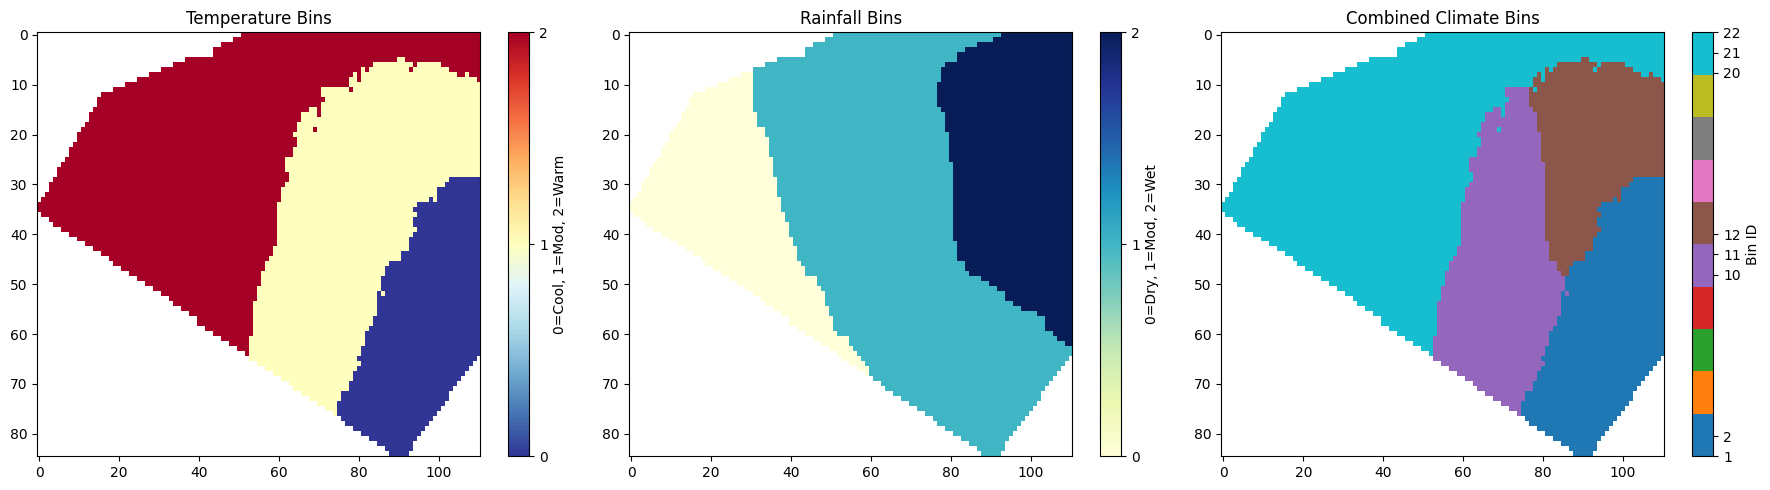

In [8]:
# Check which bins exist
print("Bins present in your data:")
print("\nBin ID | Temp      | Rain     | Pixel Count | % of Total")
print("-"*60)
for bid, count in zip(unique_bins, bin_counts):
    temp_bin = bid // 10
    rain_bin = bid % 10
    temp_label = ['Cool', 'Moderate', 'Warm'][temp_bin]
    rain_label = ['Dry', 'Moderate', 'Wet'][rain_bin]
    pct = 100 * count / valid_mask.sum()
    print(f"  {bid:2d}   | {temp_label:8s}  | {rain_label:8s} |   {count:6d}    |  {pct:5.1f}%")

# Check the 2x2 grid to see which combinations are missing
print("\n\nClimate space matrix (X = exists, - = missing):")
print("              |   Dry   | Moderate |   Wet   |")
print("--------------|---------|----------|---------|")
for t, temp_label in enumerate(['Cool     ', 'Moderate ', 'Warm     ']):
    row = f"{temp_label} |"
    for r in range(3):
        bid = t * 10 + r
        if bid in unique_bins:
            row += f"    X    |"
        else:
            row += f"    -    |"
    print(row)

# Visualize temp and rain separately to understand the correlation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature bins
temp_display = temp_binned.astype(float)
temp_display[~valid_mask] = np.nan
im1 = axes[0].imshow(temp_display, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=2)
axes[0].set_title('Temperature Bins')
plt.colorbar(im1, ax=axes[0], ticks=[0,1,2], label='0=Cool, 1=Mod, 2=Warm')

# Rainfall bins
rain_display = rain_binned.astype(float)
rain_display[~valid_mask] = np.nan
im2 = axes[1].imshow(rain_display, cmap='YlGnBu', aspect='auto', vmin=0, vmax=2)
axes[1].set_title('Rainfall Bins')
plt.colorbar(im2, ax=axes[1], ticks=[0,1,2], label='0=Dry, 1=Mod, 2=Wet')

# Combined bins
bin_display = np.ma.masked_where(bin_id == -9999, bin_id)
im3 = axes[2].imshow(bin_display, cmap='tab10', aspect='auto')
axes[2].set_title('Combined Climate Bins')
plt.colorbar(im3, ax=axes[2], ticks=unique_bins, label='Bin ID')

plt.tight_layout()
plt.show()

In [9]:
# Let's diagnose what's happening
print("Unique bins found:", unique_bins)
print("Number of bins:", len(unique_bins))

# Check the climate space more carefully
print("\nClimate space matrix (showing pixel counts):")
print("              |   Dry (0) | Moderate (1) |  Wet (2)  |")
print("--------------|-----------|--------------|-----------|")
for t in range(3):
    temp_label = ['Cool (0)    ', 'Moderate (1)', 'Warm (2)    '][t]
    row = f"{temp_label} |"
    for r in range(3):
        bid = t * 10 + r
        if bid in unique_bins:
            count = bin_counts[unique_bins == bid][0]
            row += f"  {count:6d}  |"
        else:
            row += f"     0     |"
    print(row)

# Double-check by counting manually
print("\nManual count of each combination:")
for t in range(3):
    for r in range(3):
        mask_combo = (temp_binned == t) & (rain_binned == r) & valid_mask
        count = mask_combo.sum()
        bid = t * 10 + r
        if count > 0:
            print(f"  Bin {bid} (temp={t}, rain={r}): {count} pixels")

# Check if there's an issue with the bin_id calculation
print("\nChecking bin_id calculation:")
print(f"temp_binned range: {temp_binned[valid_mask].min()} to {temp_binned[valid_mask].max()}")
print(f"rain_binned range: {rain_binned[valid_mask].min()} to {rain_binned[valid_mask].max()}")
print(f"bin_id range: {bin_id[valid_mask].min()} to {bin_id[valid_mask].max()}")

Unique bins found: [ 1  2 10 11 12 20 21 22]
Number of bins: 8

Climate space matrix (showing pixel counts):
              |   Dry (0) | Moderate (1) |  Wet (2)  |
--------------|-----------|--------------|-----------|
Cool (0)     |     0     |     703  |     498  |
Moderate (1) |      24  |    1298  |     954  |
Warm (2)     |    1247  |    1522  |     185  |

Manual count of each combination:
  Bin 1 (temp=0, rain=1): 703 pixels
  Bin 2 (temp=0, rain=2): 498 pixels
  Bin 10 (temp=1, rain=0): 24 pixels
  Bin 11 (temp=1, rain=1): 1298 pixels
  Bin 12 (temp=1, rain=2): 954 pixels
  Bin 20 (temp=2, rain=0): 1247 pixels
  Bin 21 (temp=2, rain=1): 1522 pixels
  Bin 22 (temp=2, rain=2): 185 pixels

Checking bin_id calculation:
temp_binned range: 0 to 2
rain_binned range: 0 to 2
bin_id range: 1 to 22


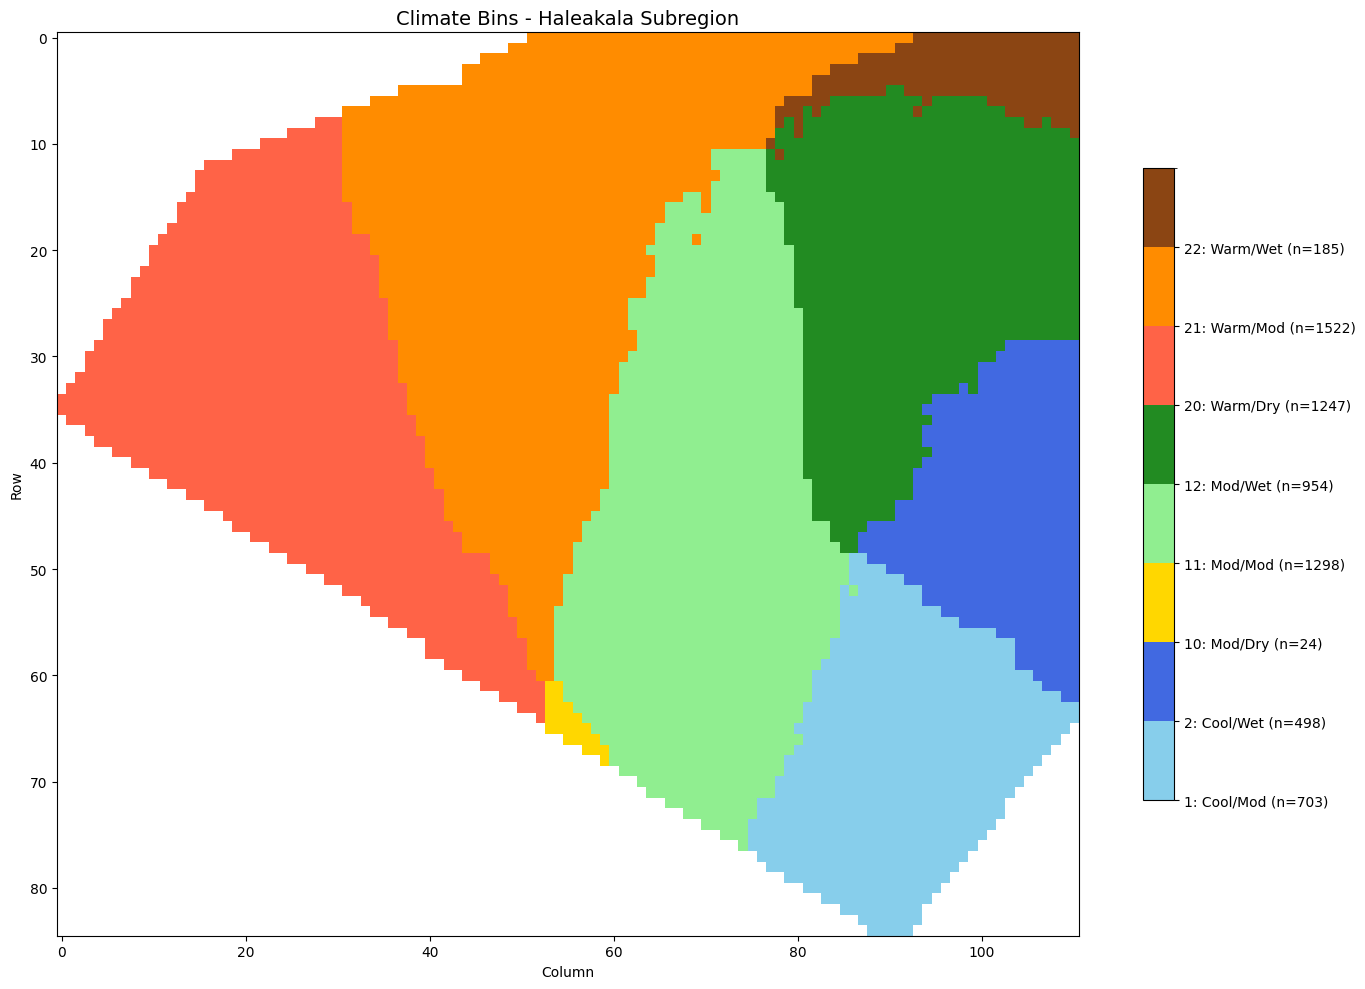


✓ You have 8 climate bins (missing only bin 00: Cool/Dry)
✓ This makes ecological sense - high elevation areas on Maui are wet (windward)


In [10]:
# Create a better visualization with discrete colors
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define explicit colors for each bin
bin_colors = {
    1: '#87CEEB',   # Cool/Moderate - Sky Blue
    2: '#4169E1',   # Cool/Wet - Royal Blue
    10: '#FFD700',  # Moderate/Dry - Gold
    11: '#90EE90',  # Moderate/Moderate - Light Green
    12: '#228B22',  # Moderate/Wet - Forest Green
    20: '#FF6347',  # Warm/Dry - Tomato Red
    21: '#FF8C00',  # Warm/Moderate - Dark Orange
    22: '#8B4513',  # Warm/Wet - Saddle Brown
}

# Create custom colormap
colors = [bin_colors[bid] for bid in sorted(unique_bins)]
cmap = ListedColormap(colors)
bounds = list(unique_bins) + [unique_bins[-1] + 1]
norm = BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
bin_display = np.ma.masked_where(bin_id == -9999, bin_id)

im = ax.imshow(bin_display, cmap=cmap, norm=norm, interpolation='nearest', aspect='auto')

# Create colorbar with proper labels
cbar = plt.colorbar(im, ax=ax, ticks=unique_bins, shrink=0.7)
bin_labels = []
for bid in unique_bins:
    temp_bin = bid // 10
    rain_bin = bid % 10
    temp_label = ['Cool', 'Mod', 'Warm'][temp_bin]
    rain_label = ['Dry', 'Mod', 'Wet'][rain_bin]
    count = bin_counts[unique_bins == bid][0]
    bin_labels.append(f'{bid}: {temp_label}/{rain_label} (n={count})')
cbar.ax.set_yticklabels(bin_labels, fontsize=10)

ax.set_title('Climate Bins - Haleakala Subregion', fontsize=14)
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.grid(False)
plt.tight_layout()
plt.show()

In [20]:
# New bin strategy:
# - Cool areas: only 1 bin (all rainfall combined)
# - Combine Moderate/Dry (10) with Moderate/Moderate (11) → call it "Moderate/Dry-Moderate"
# - Combine Warm/Moderate (21) with Warm/Wet (22) → call it "Warm/Moderate-Wet"

# Custom binning approach
temp_edges = [15, 22, 26, 29]  # Keep same: Cool, Moderate, Warm

# Different rain edges for different temp zones
rain_edges_moderate = [300, 1607, 6100]  # Moderate: Dry-Moderate, Wet (merge first two)
rain_edges_warm = [300, 500, 6100]  # Warm: Dry, Moderate-Wet (merge last two)

# Create new binned array
temp_binned = np.digitize(temp, temp_edges, right=False) - 1
temp_binned = np.clip(temp_binned, 0, 2)

# Create rain bins that depend on temperature
rain_binned = np.full(rain.shape, -1)

# For cool areas (temp bin 0): only 1 rain bin (all = bin 1)
cool_mask = (temp_binned == 0) & valid_mask
rain_binned[cool_mask] = 1  # Force all cool areas to rain bin 1

# For moderate areas (temp bin 1): 2 rain bins (dry-moderate=0, wet=1)
mod_mask = (temp_binned == 1) & valid_mask
rain_binned[mod_mask] = np.digitize(rain[mod_mask], rain_edges_moderate, right=False) - 1
rain_binned[mod_mask] = np.clip(rain_binned[mod_mask], 0, 1)

# For warm areas (temp bin 2): 2 rain bins (dry=0, moderate-wet=1)
warm_mask = (temp_binned == 2) & valid_mask
rain_binned[warm_mask] = np.digitize(rain[warm_mask], rain_edges_warm, right=False) - 1
rain_binned[warm_mask] = np.clip(rain_binned[warm_mask], 0, 1)

# Create combined bin ID
bin_id = np.full(temp.shape, -9999)
bin_id[valid_mask] = temp_binned[valid_mask] * 10 + rain_binned[valid_mask]

# Check new bin counts
unique_bins, bin_counts = np.unique(bin_id[valid_mask], return_counts=True)

print("="*70)
print("Revised Climate Bins (5 total)")
print("="*70)
print("Bin ID | Temp      | Rain            | Pixel Count | % of Total")
print("-"*70)

bin_descriptions = {
    1: ("Cool", "All rainfall"),
    10: ("Moderate", "Dry-Moderate (<1607mm)"),
    11: ("Moderate", "Wet (>1607mm)"),
    20: ("Warm", "Dry (<500mm)"),
    21: ("Warm", "Moderate-Wet (>500mm)"),
}

for bid, count in zip(unique_bins, bin_counts):
    temp_bin = bid // 10
    rain_bin = bid % 10
    if bid in bin_descriptions:
        temp_label, rain_label = bin_descriptions[bid]
        pct = 100 * count / valid_mask.sum()
        print(f"  {bid:2d}   | {temp_label:9s} | {rain_label:15s} |   {count:6d}    |  {pct:5.1f}%")

print("-"*70)
print(f"Total: {len(unique_bins)} bins, {valid_mask.sum()} pixels")

Revised Climate Bins (5 total)
Bin ID | Temp      | Rain            | Pixel Count | % of Total
----------------------------------------------------------------------
   1   | Cool      | All rainfall    |     1201    |   18.7%
  10   | Moderate  | Dry-Moderate (<1607mm) |     1082    |   16.8%
  11   | Moderate  | Wet (>1607mm)   |     1194    |   18.6%
  20   | Warm      | Dry (<500mm)    |     1247    |   19.4%
  21   | Warm      | Moderate-Wet (>500mm) |     1707    |   26.5%
----------------------------------------------------------------------
Total: 5 bins, 6431 pixels


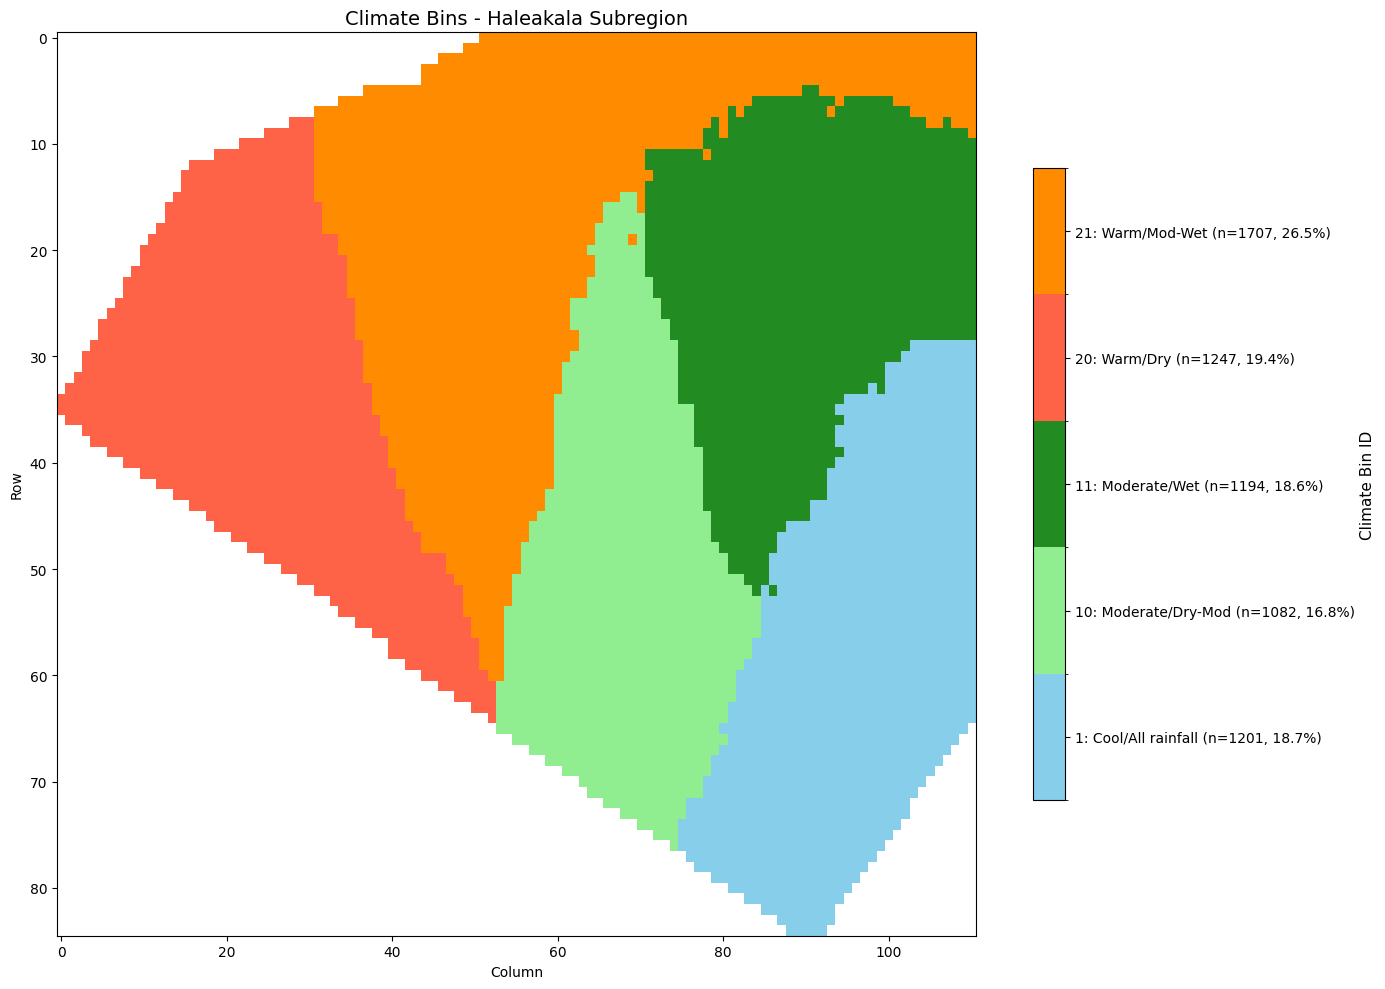

In [24]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Your bin colors (5 bins)
bin_colors = {
    1: '#87CEEB',   # Cool/Moderate - Sky Blue
    10: '#90EE90',  # Moderate/Dry-Moderate - Light Green
    11: '#228B22',  # Moderate/Wet - Forest Green
    20: '#FF6347',  # Warm/Dry - Tomato Red
    21: '#FF8C00',  # Warm/Moderate-Wet - Dark Orange
}

# Updated descriptions
bin_descriptions = {
    1: ("Cool", "All rainfall"),
    10: ("Moderate", "Dry-Mod"),
    11: ("Moderate", "Wet"),
    20: ("Warm", "Dry"),
    21: ("Warm", "Mod-Wet"),
}

# Create custom colormap
colors = [bin_colors[bid] for bid in sorted(unique_bins)]
cmap = ListedColormap(colors)
bounds = list(unique_bins) + [unique_bins[-1] + 1]
norm = BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
bin_display = np.ma.masked_where(bin_id == -9999, bin_id)

im = ax.imshow(bin_display, cmap=cmap, norm=norm, interpolation='nearest', aspect='auto')

# Create colorbar with ticks in the CENTER of each color block
cbar = plt.colorbar(im, ax=ax, shrink=0.7)

# Calculate centered tick positions
tick_positions = []
for i in range(len(unique_bins)):
    if i < len(unique_bins) - 1:
        center = (unique_bins[i] + unique_bins[i+1]) / 2
    else:
        # For the last bin, center it within its range
        center = unique_bins[i] + 0.5
    tick_positions.append(center)

cbar.set_ticks(tick_positions)

# Create labels
bin_labels = []
for bid in unique_bins:
    temp_label, rain_label = bin_descriptions[bid]
    count = bin_counts[unique_bins == bid][0]
    pct = 100 * count / valid_mask.sum()
    bin_labels.append(f'{bid}: {temp_label}/{rain_label} (n={count}, {pct:.1f}%)')

cbar.ax.set_yticklabels(bin_labels, fontsize=10)
cbar.set_label('Climate Bin ID', fontsize=11)

ax.set_title('Climate Bins - Haleakala Subregion', fontsize=14)
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.grid(False)
plt.tight_layout()
plt.show()

In [25]:
import rasterio

# Save the binned climate data as a GeoTIFF
output_file = 'climate_bins.tif'

# Copy metadata from the original temperature file
with rasterio.open('/content/T_max_ann_subregion.tif') as src:
    meta = src.meta.copy()

# Update metadata for the new file
meta.update({
    'dtype': 'int16',  # Climate bins are integers
    'nodata': -9999,
    'count': 1  # Single band
})

# Write the climate bins to file
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(bin_id.astype('int16'), 1)

print(f"✓ Saved climate bins to {output_file}")
print(f"  - NoData value: -9999")
print(f"  - Bin values: {sorted(unique_bins)}")
print(f"  - CRS: {meta['crs']}")
print(f"  - Size: {meta['height']} x {meta['width']}")

✓ Saved climate bins to climate_bins.tif
  - NoData value: -9999
  - Bin values: [np.int64(1), np.int64(10), np.int64(11), np.int64(20), np.int64(21)]
  - CRS: EPSG:32604
  - Size: 85 x 111
